# 심화 학습 : 선형 회귀

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## 단순 선형 회귀

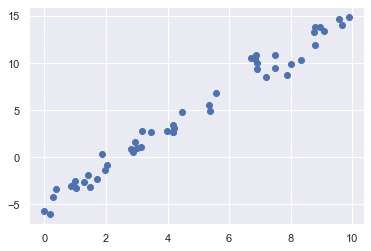

In [2]:
rng = np.random.RandomState(1)
x = 10*rng.rand(50)
y = 2*x - 5 + rng.randn(50)
plt.scatter(x, y)

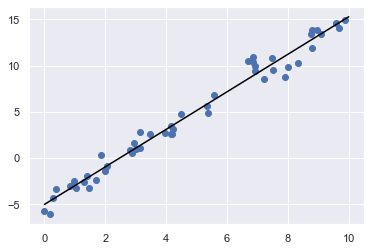

In [3]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)
model.fit(x[:,np.newaxis], y)

xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit, color='black')

In [4]:
print("Model slope : ", model.coef_[0].round(5))
print("Model intercept : ", model.intercept_.round(5))

Model slope :  2.02721
Model intercept :  -4.99858


In [5]:
rng = np.random.RandomState(1)
X = 10*rng.rand(100, 3)
y = 0.5 + np.dot(X, [1.5, -2, 1.])

model.fit(X, y)
print(model.intercept_.round(5))
print(model.coef_.round(5))

0.5
[ 1.5 -2.   1. ]


## 기저 함수 회귀

* 선형 회귀를 비선형 관계에 적응시키는 데 사용할 수 있는 비법은 데이터를 `기저 함수(basis function)`에 따라 변환하는 것

### 다항식 기저 함수

In [6]:
from sklearn.preprocessing import PolynomialFeatures
x = np.array([2, 3, 4])
poly = PolynomialFeatures(3, include_bias = False)
poly.fit_transform(x[:, None])

array([[ 2.,  4.,  8.],
       [ 3.,  9., 27.],
       [ 4., 16., 64.]])

In [7]:
from sklearn.pipeline import make_pipeline
poly_model = make_pipeline(PolynomialFeatures(7), LinearRegression())

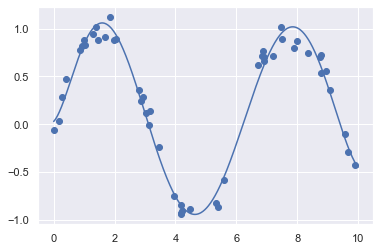

In [8]:
# 비선형 훈련 데이터에 선형 다항식 접합

rng = np.random.RandomState(1)
x = 10*rng.rand(50)
y = np.sin(x) + 0.1*rng.randn(50)

poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)

### 가우스 기저 함수

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):
    ''' 1차원 입력에 대해 균일한 간격을 가지는 가우시안 특징 '''
    def __init__(self, N, width_factor = 2.0):
        self.N = N
        self.width_factor = width_factor
    @staticmethod
    
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5*np.sum(arg ** 2, axis))
    
    def fit(self, X, y=None):
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
    
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_, self.width_, axis=1)

In [10]:
gauss_model = make_pipeline(GaussianFeatures(20), LinearRegression())
gauss_model.fit(x[:, np.newaxis], y)

Pipeline(steps=[('gaussianfeatures', GaussianFeatures(N=20)),
                ('linearregression', LinearRegression())])

(0.0, 10.0)

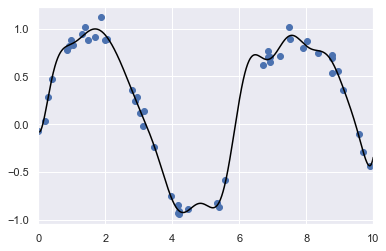

In [11]:
yfit = gauss_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit, color='black')
plt.xlim(0, 10)

### 정규화

(-1.5, 1.5)

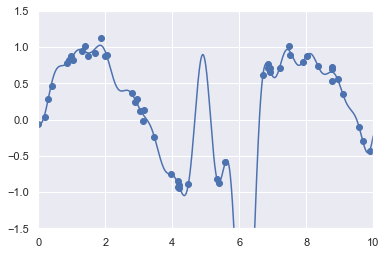

In [12]:
model = make_pipeline(GaussianFeatures(30), LinearRegression())
model.fit(x[:, np.newaxis], y)

plt.scatter(x, y)
plt.plot(xfit, model.predict(xfit[:, np.newaxis]))

plt.xlim(0, 10)
plt.ylim(-1.5, 1.5)

In [13]:
def basis_plot(model, title=None):
    fig, ax = plt.subplots(2, sharex=True)
    model.fit(x[:, np.newaxis], y)
    ax[0].scatter(x, y)
    ax[0].plot(xfit, model.predict(xfit[:, np.newaxis]))
    ax[0].set(xlabel = 'x', ylabel = 'y', ylim = (-1.5, 1.5))
    
    if title:
        ax[0].set_title(title)
    
    ax[1].plot(model.steps[0][1].centers_, model.steps[1][1].coef_)
    ax[1].set(xlabel = 'basis location', ylabel = 'coefficient', xlim = (0, 10))

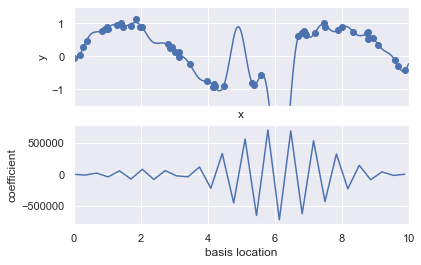

In [14]:
model = make_pipeline(GaussianFeatures(30), LinearRegression())
basis_plot(model)

### 능선 회귀 (L2 정규화)

* Ridge Regression = 능선 회귀

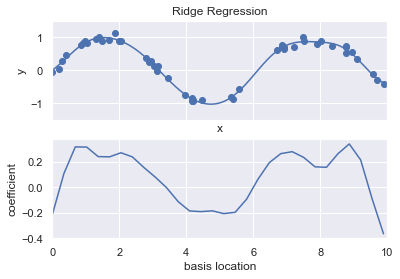

In [15]:
from sklearn.linear_model import Ridge
model = make_pipeline(GaussianFeatures(30), Ridge(alpha=0.1))
basis_plot(model, title = 'Ridge Regression')

### 라쏘 정규화 (L1 정규화)

C:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021358158704865016, tolerance: 0.002065280097246271
  positive)


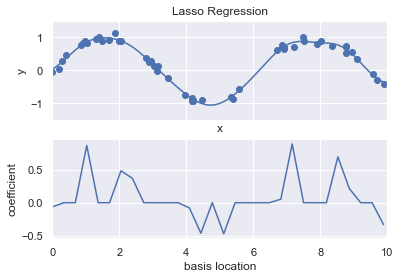

In [16]:
from sklearn.linear_model import Lasso
model = make_pipeline(GaussianFeatures(30), Lasso(alpha=0.001))
basis_plot(model, title = 'Lasso Regression')

## 예제 : 자전거 통행량 예측

In [17]:
import pandas as pd
counts = pd.read_csv('./FremontBridge.csv', index_col = 'Date', parse_dates=True)
weather = pd.read_csv('./BicycleWeather.csv', index_col = 'DATE', parse_dates=True)

In [18]:
daily = counts.resample('d').sum()
daily = daily.iloc[:, 1:]
daily['Total'] = daily.mean(axis=1)
daily = daily[['Total']]

In [19]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

In [20]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

In [21]:
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude)) * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

In [22]:
daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


In [23]:
daily = daily[:1063]
daily

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs
Date,,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208
...,...,...,...,...,...,...,...,...,...,...
2015-08-27,4336.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,13.474738
2015-08-28,2653.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,13.418591
2015-08-29,699.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,13.362212


(8.0, 17.0)

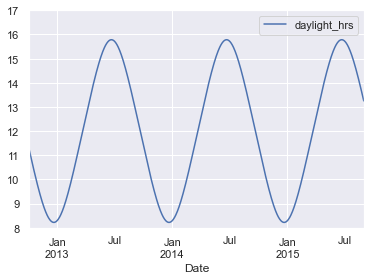

In [24]:
daily[['daylight_hrs']].plot();
plt.ylim(8, 17)

In [25]:
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])

In [26]:
daily['annual'] = (daily.index - daily.index[0]).days / 365.

In [27]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,5.60,1,0.000000
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,5.65,1,0.002740
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,5.95,1,0.005479
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,6.05,1,0.008219
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,6.05,1,0.010959


In [28]:
daily.dropna(axis=0, how='any', inplace=True)

column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday', 'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual']
X = daily[column_names]
y = daily['Total']

model = LinearRegression(fit_intercept = False)
model.fit(X, y)
daily['predicted'] = model.predict(X)

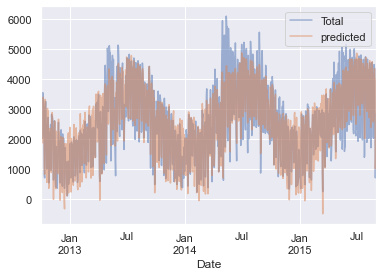

In [29]:
daily[['Total', 'predicted']].plot(alpha=0.5)

In [30]:
params = pd.Series(model.coef_, index=X.columns)
params

Mon               -654.966728
Tue               -546.456104
Wed               -567.056839
Thu               -677.289038
Fri               -981.724979
Sat              -2262.944085
Sun              -2293.142571
holiday          -1186.956224
daylight_hrs       128.876901
PRCP           -169040.096072
dry day            546.535874
Temp (C)           362.058793
annual              27.934890
dtype: float64

In [31]:
from sklearn.utils import resample
np.random.seed(1)
err = np.std([model.fit(*resample(X, y)).coef_ for i in range(1000)], 0)

In [32]:
display(pd.DataFrame({'effect' : params.round(0), 'error' : err.round(0)}))

,effect,error
Mon,-655.0,83.0
Tue,-546.0,83.0
Wed,-567.0,83.0
Thu,-677.0,82.0
Fri,-982.0,82.0
Sat,-2263.0,78.0
Sun,-2293.0,78.0
holiday,-1187.0,164.0
daylight_hrs,129.0,9.0
PRCP,-169040.0,15837.0
